In [145]:
import sys
sys.path.insert(0, '/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/src')

In [418]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from model import MaxEncoder
from MnistSet import MNISTSet
from MnistSet import get_loader
import trimesh
from matplotlib import pyplot as plt
import numpy as np
import h5py
from torch.utils.data import DataLoader, Dataset, TensorDataset
from time import sleep
from tqdm import tqdm

In [581]:
DATA_DIR = "/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/DeepSets Clasification PointCloud/10/raw"

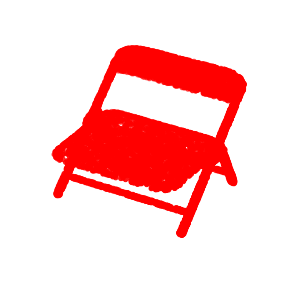

In [586]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
points = mesh.sample(10000)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],color = 'r')
ax.set_axis_off()
plt.show()


In [169]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: bed
processing class: monitor
processing class: desk
processing class: chair
processing class: dresser
processing class: toilet
processing class: sofa
processing class: table
processing class: night_stand
processing class: bathtub


In [333]:
train_points[0]

array([[ 23.06605756, -38.63527577,   6.4624    ],
       [ -7.14184149,  12.86429609,  -5.3071    ],
       [ 11.1825    , -31.88255005, -15.84869184],
       ...,
       [  2.30348181,  38.829     ,  -5.54678823],
       [  7.08293089, -17.35180101, -16.7497    ],
       [  8.78074202, -35.893     ,  -8.93111214]])

In [174]:
h5f = h5py.File('pointcloud.h5', 'w')
h5f.create_dataset('train_points', data=train_points)
h5f.create_dataset('test_points', data=test_points)
h5f.create_dataset('train_labels', data=train_labels)
h5f.create_dataset('test_labels', data=test_labels)
h5f.close()

In [609]:
h5f.close()

In [645]:
h5f = h5py.File('pointcloud.h5','r')
train_points = h5f['train_points'][:]
test_points = h5f['test_points'][:]
train_labels = h5f['train_labels'][:]
test_labels = h5f['test_labels'][:]

In [639]:
train_points[0]

array([[ 23.06605756, -38.63527577,   6.4624    ],
       [ -7.14184149,  12.86429609,  -5.3071    ],
       [ 11.1825    , -31.88255005, -15.84869184],
       ...,
       [  2.30348181,  38.829     ,  -5.54678823],
       [  7.08293089, -17.35180101, -16.7497    ],
       [  8.78074202, -35.893     ,  -8.93111214]])

In [644]:
#train_points = train_points.reshape(train_points.shape[0],3,2048)
#test_points = test_points.reshape(test_points.shape[0],3,2048)

In [613]:
train_points.shape

(3991, 2048, 3)

In [614]:
train_labels[800]

1

In [646]:
# Les aplicamos un poco de ruido a las figuras y les metemos un suffle
def augment(points):
    # jitter points
    points += np.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = np.random.shuffle(points)
    return points
torch_train = TensorDataset(torch.from_numpy(train_points).float(), torch.from_numpy(train_labels).long())
torch_test = TensorDataset(torch.from_numpy(test_points).float(), torch.from_numpy(test_labels).long())

    

In [647]:
train_loader = DataLoader(torch_train, batch_size=32)
test_loader = DataLoader(torch_test, batch_size=32)

In [648]:
data_iter = iter(train_loader)
p,l=data_iter.next()

In [649]:
p,l=data_iter.next()
l

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [650]:
a =p.squeeze(0).transpose(1,2).numpy()
print(a.shape)

(32, 3, 2048)


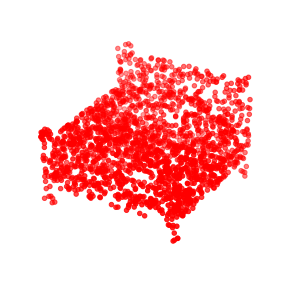

In [651]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(a[0,0,:], a[0,1,:], a[0,2, :],color = 'r')
ax.set_axis_off()
plt.show()

In [673]:
set_channels = 3
set_size = 2048
  
hidden_dim = 128
iters = 10
latent_dim = 64
lr = 0.001
n_epochs = 100
net = MaxEncoder(set_channels,latent_dim,hidden_dim)

In [674]:
net

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [675]:
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=0.001)

In [676]:
net.train()
for epoch in range(n_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, sample in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            points, label = map(lambda x: x, sample)
            #print(points.shape)
            optimizer.zero_grad()
            mask = torch.ones(32,2048)
            output = net(points.transpose(1,2),mask)
            loss = F.cross_entropy(output, label)
            acc = (output.max(dim=1)[1] == label).float().mean()
            #print(output.max(dim=1))
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 0:  39%|███████████████████▉                               | 49/125 [00:24<00:38,  1.97batch/s, acc=100, loss=1.28]


KeyboardInterrupt: 